   #  TV-Sales Forecasting                                                         
                                                                                                           
                                                                                                           ENES_YILDIZ
                                                                                                           

   To forecast -Tv sales in 2020, because of small dataset with many variables but low number of observations, I decided to go with one of the neural network time series forecasting method LSTM. By doing that I also used VAR model codes in other document to see trends,outliers,granger causality test and stationarity(Var(3)). However VAR model was not good enough to explain TV-sales with given dataset.
   
   Steps

1- Necessary libraries uploaded-Tensorflow and Keras 

2- Data upload and check it- Cleaning and examinin the data

3- Visual check for trend and null values or outliers-Ready to use phase

4- Data splitting before scaling

5- Scaling process

6- Testing and hyperparameter tuning phases

7- Best parameter testing and test prediction

8- Creating necessary dataframes after prediction

9- Inverse Scaling process

10- Comparison Dataframe and Visualization

11- Comment

                                                                                                              

In [1]:
import numpy as np      
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from math import sqrt
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
#data is uploaded
data=pd.read_excel('TV_Sales.xlsx', index_col=0,sheet_name='TV', parse_dates=True)
data.head()

,id,ay,ceyrek,mevsim,mevsim_2,mevsim_3,yil,TV_Pazar,google_tv,google_bzd,...,Germany_PMI,France_PMI,China_PMI,Italy_PMI,US_PMI,UK_PMI,Spain_PMI,pmi,gercek_yp_mevduat,reel_döviz
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,13,1,1,1,1,1,2012,495092.755595,49,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.92
2012-02-01,14,2,1,1,1,1,2012,471891.269247,56,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.87
2012-03-01,15,3,1,2,1,2,2012,489523.107594,46,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.30
2012-04-01,16,4,2,2,2,2,2012,474710.298413,48,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.92
2012-05-01,17,5,2,2,2,2,2012,526222.311015,43,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.41


In [3]:
#null check
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2012-01-01 to 2020-04-01
Data columns (total 73 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   100 non-null    int64  
 1   ay                                   100 non-null    int64  
 2   ceyrek                               100 non-null    int64  
 3   mevsim                               100 non-null    int64  
 4   mevsim_2                             100 non-null    int64  
 5   mevsim_3                             100 non-null    int64  
 6   yil                                  100 non-null    int64  
 7   TV_Pazar                             99 non-null     float64
 8   google_tv                            100 non-null    int64  
 9   google_bzd                           100 non-null    int64  
 10  google_cm                            100 non-null    int64  
 11  google_dolar 

In [4]:
#target info and check
data['TV_Pazar'].describe()

count        99.000000
mean     502255.561807
std       79632.276798
min      328424.493408
25%      459529.669085
50%      493437.760524
75%      547548.347266
max      707181.663621
Name: TV_Pazar, dtype: float64

In [5]:
#some critical variables to examine in further steps
not_used=['id','yil','ay','ceyrek']
kategorik=['otv','futbol','mevsim','mevsim_2','mevsim_3','secim']
non_numeric=not_used+kategorik
null_cols=['Germany_PMI','France_PMI','China_PMI','Italy_PMI','US_PMI','UK_PMI','Spain_PMI','pmi']

In [6]:
data_numeric=data.drop(non_numeric,axis=1)
data_numeric.columns

Index(['TV_Pazar', 'google_tv', 'google_bzd', 'google_cm', 'google_dolar',
       'google_euro', 'google_doviz', 'google_marka', 'Enflasyon',
       'güven_endeksi', 'euro', 'euro_degisim', 'dolar', 'dolar_degisim',
       'perakende_endeks_elektrikli', 'perakende_endeks_elektrikli_mev_tak',
       'day_tuk_egilim', 'eko_durum', 'eko_durum_beklenti', 'mali_durum',
       'maddi_durum_beklenti', 'maddi_durum', 'daya_tuk_uygunluk',
       'tasarruf_uygunluk', 'otomobil_alma', 'tuketici_fiyat_beklenti',
       'tuketici_fiyat_dusunce', 'guven_endeks', 'issiz_beklenti',
       'European Union_CC', 'Euro area_CC', 'Germany_CC', 'Spain_CC',
       'France_CC', 'Italy_CC', 'United Kingdom_CC', 'Turkey_CC',
       'European Union_RC', 'Euro area_RC', 'Germany_RC', 'Spain_RC',
       'France_RC', 'Italy_RC', 'United Kingdom_RC', 'Turkey_RC',
       'European Union_ES', 'Euro area_ES', 'Germany_ES', 'Spain_ES',
       'France_ES', 'Italy_ES', 'United Kingdom_ES', 'Turkey_ES',
       'Germany_PMI

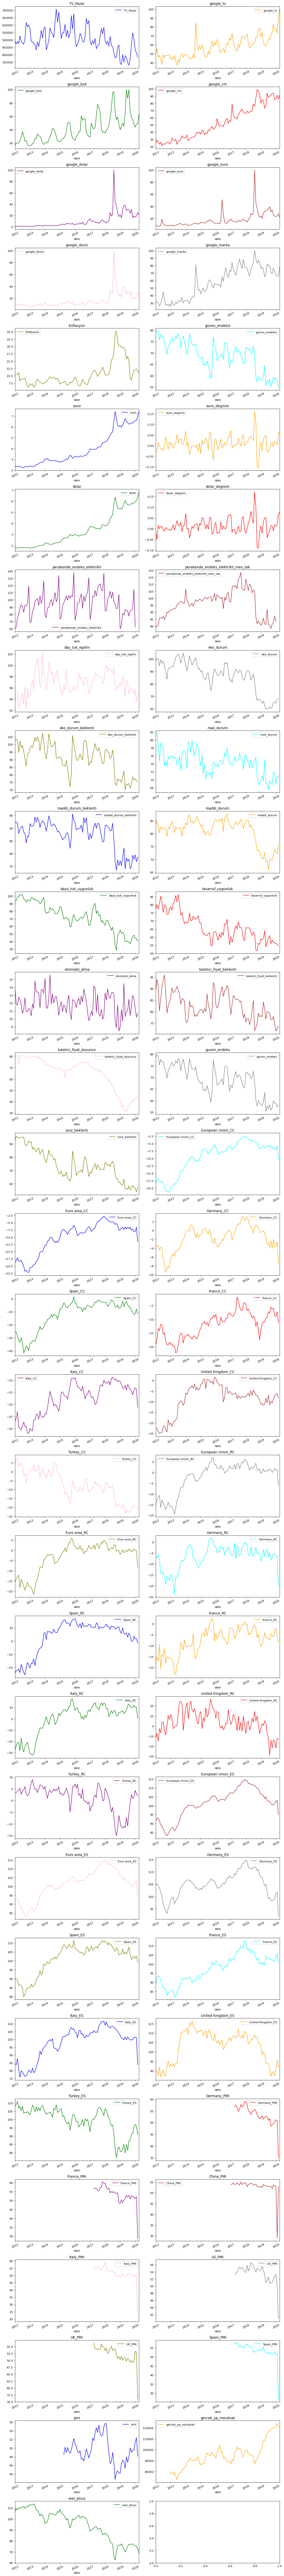

In [7]:
#Visualize all columns to see general trends and spread of variables
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
def Visualize(data):
    features= list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(data_numeric)

# NULL handling 

Few columns(PMI columns in general-later they will appear as non-crucial variables) are almost 40% full therefore we need to take care null values with appropriate logic.
In time series interpolate and bfill functions are usefull to full null columns. 

In [8]:
filled_data=data.bfill().interpolate().dropna()
input_data=filled_data.drop(not_used,axis=1)

In [9]:
#after null handling
input_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2012-01-01 to 2020-04-01
Data columns (total 69 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   mevsim                               100 non-null    int64  
 1   mevsim_2                             100 non-null    int64  
 2   mevsim_3                             100 non-null    int64  
 3   TV_Pazar                             100 non-null    float64
 4   google_tv                            100 non-null    int64  
 5   google_bzd                           100 non-null    int64  
 6   google_cm                            100 non-null    int64  
 7   google_dolar                         100 non-null    int64  
 8   google_euro                          100 non-null    int64  
 9   google_doviz                         100 non-null    int64  
 10  google_marka                         100 non-null    int64  
 11  Enflasyon    

Train and test datasets are decided in this section. Since we have small data, we need to scale carefully before we put data into model.

In [109]:
#threshold to split data
split=80

In [110]:
#train & test split
train = input_data.iloc[:split]
test = input_data.iloc[split:]
train.shape,test.shape

((80, 69), (20, 69))

# Scaling phase#
To apply LSTM, data should be scaled and transform according to LSTM.

In [131]:
scaler =MinMaxScaler() 
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

# To protect categorical variables after scaling process
train_scaled[:,1]=[0 if train_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(train_scaled[:,1]))]
train_scaled[:,13]=[0 if train_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(train_scaled[:,1]))]
train_scaled[:,14]=[0 if train_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(train_scaled[:,1]))]
train_scaled[:,34]=[0 if train_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(train_scaled[:,1]))]
test_scaled[:,1]=[0 if test_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(test_scaled[:,1]))]
test_scaled[:,13]=[0 if test_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(test_scaled[:,1]))]
test_scaled[:,14]=[0 if test_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(test_scaled[:,1]))]
test_scaled[:,34]=[0 if test_scaled[:,1][cols] < 0.5 else 1 for cols in range(len(test_scaled[:,1]))]

In [132]:
#Splitting process should be done after scaling process, otherwise data could learn test_set thus it may lead overfitting. 
x_train=train_scaled
x_test=test_scaled
y_train=train_scaled[:,3]
y_test=test_scaled
x_train.shape,x_test.shape,y_train.shape, y_test.shape

((80, 69), (20, 69), (80,), (20, 69))

# LSTM FORECASTING PROCESS

After splitting datasets, model will be trained and validated in this phase. Window length,batch-size,epoch all are tuned until find the optimal model output.

In [133]:
#LSTM PREDICTION PHASE-LAG-BATCH-EPOCH-PARAMETER TUNING

In [139]:
window_length=5
batch_size=1
num_features=69
train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

 Dropout level is taken as 0.2 and added more layers to models in order to deep determination.

In [135]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (window_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.Dense(1))

In [136]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 8, 128)            101376    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 8, 128)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 8, 128)            131584    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 8, 128)            0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 8, 128)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)              

# Loss Level
Test data loss values are indicated in this section according to tuning parameters.

In [137]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=100,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/100


C:\Users\menes\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


15/15 [==============================] - 7s 104ms/step - loss: 0.1057 - mean_absolute_error: 0.2520 - val_loss: 0.2299 - val_mean_absolute_error: 0.3992
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 0.1046 - mean_absolute_error: 0.2549 - val_loss: 0.0967 - val_mean_absolute_error: 0.2633
Epoch 3/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0534 - mean_absolute_error: 0.1851 - val_loss: 0.1074 - val_mean_absolute_error: 0.2747
Epoch 4/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0447 - mean_absolute_error: 0.1754 - val_loss: 0.1175 - val_mean_absolute_error: 0.2856


In [138]:
model.evaluate_generator(test_generator, verbose=0)

C:\Users\menes\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.11751019954681396, 0.28557288646698]

# Prediction

In [119]:
predictions=model.predict_generator(test_generator)

C:\Users\menes\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [120]:
predictions_train=model.predict_generator(train_generator)

In [140]:
x_train_df=pd.DataFrame(x_train[:,0:][window_length:])
predictions_train_df=pd.DataFrame(predictions_train)
x_train_df[3]=predictions_train_df[0]
x_train_df.shape

(75, 69)

In [141]:
x_test_df=pd.DataFrame(x_test[:,0:][window_length:])
predictions_df=pd.DataFrame(predictions)
x_test_df[3]=predictions_df[0]
x_test_df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.000000,0.0,0.0,0.107393,0.365854,0.083333,0.461538,0.000000,0.00,0.105263,...,0.890,0.849802,0.932540,0.913043,1.000000,0.856354,0.933798,0.381443,0.377398,0.995299
1,0.333333,0.0,0.5,0.021273,0.097561,0.166667,0.423077,0.576923,0.36,0.473684,...,0.820,0.790514,0.996032,0.972050,0.938356,0.773481,1.000000,0.463918,0.564432,0.859637
2,0.333333,1.0,0.5,-0.056237,0.000000,0.083333,0.000000,0.846154,0.44,0.605263,...,0.860,0.837945,0.972222,0.909938,0.828767,0.823204,0.912892,0.422680,0.536685,0.686367
3,0.333333,1.0,0.5,-0.151704,0.000000,0.400000,0.153846,0.846154,0.52,0.500000,...,0.880,0.881423,0.968254,0.922360,0.684932,0.823204,0.885017,0.268041,0.632775,0.498993
4,0.666667,1.0,1.0,-0.234863,0.073171,1.000000,0.807692,0.500000,0.52,0.236842,...,0.880,0.940711,0.956349,0.928571,0.726027,0.756906,0.885017,0.536082,0.732824,0.658831
5,0.666667,1.0,1.0,NaN,0.195122,0.783333,0.576923,0.576923,0.64,0.368421,...,0.795,0.909091,0.960317,0.956522,0.801370,0.812155,0.871080,0.412371,0.776761,0.839490
6,0.666667,1.0,1.0,NaN,0.170732,1.000000,0.653846,0.538462,0.76,0.342105,...,0.835,0.948617,0.956349,0.934783,0.671233,0.784530,0.902439,0.546392,0.795504,0.969107
7,1.000000,1.0,0.5,NaN,0.292683,0.450000,0.692308,0.307692,0.44,0.210526,...,0.675,0.865613,0.960317,0.944099,0.691781,0.734807,0.871080,0.752577,0.850554,0.963062
8,1.000000,0.0,0.5,NaN,0.365854,0.300000,0.807692,0.576923,0.56,0.315789,...,0.695,0.936759,0.916667,0.950311,0.684932,0.773481,0.853659,0.649485,0.855895,0.969778
9,1.000000,0.0,0.5,NaN,0.585366,0.266667,0.807692,0.000000,0.20,0.000000,...,0.720,0.916996,0.984127,0.913043,0.760274,0.734807,0.878049,0.701031,0.890214,1.000000


In [48]:
df_pred_train=x_train_df
df_pred_train.shape

(75, 69)

In [49]:
df_pred=x_test_df
df_pred

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,-1.205199,0.0,-1.300022,-0.393123,0.094134,-0.854342,-0.503080,-1.304747,-1.440551,-0.878762,...,0.564930,0.159389,0.093415,0.268558,0.988664,0.441463,0.428377,-0.365175,-0.746038,0.915272
1,-0.374027,0.0,0.229416,-0.249988,-0.995843,-0.561759,-0.660292,0.568096,-0.053924,0.603487,...,0.294536,-0.055036,0.395364,0.478974,0.759335,0.120009,0.669538,-0.045896,-0.156924,0.362221
2,-0.374027,1.0,0.229416,0.125132,-1.392198,-0.854342,-2.389630,1.442089,0.254215,1.132862,...,0.449047,0.116504,0.282133,0.257483,0.351638,0.312881,0.352221,-0.205536,-0.244321,-0.344151
3,-0.374027,1.0,0.229416,0.053571,-1.392198,0.257473,-1.760780,1.442089,0.562354,0.709362,...,0.526302,0.273749,0.263262,0.301781,-0.183463,0.312881,0.250680,-0.804183,0.058341,-1.108018
4,0.457144,1.0,1.758854,0.218056,-1.094932,2.364069,0.911832,0.318383,0.562354,-0.349387,...,0.526302,0.488175,0.206646,0.323930,-0.030577,0.055719,0.250680,0.233472,0.373474,-0.456404
5,0.457144,1.0,1.758854,0.861859,-0.599488,1.603354,-0.031442,0.568096,1.024563,0.179987,...,0.197967,0.373815,0.225518,0.423601,0.249714,0.270021,0.199909,-0.245445,0.511864,0.280085
6,0.457144,1.0,1.758854,1.882271,-0.698576,2.364069,0.282982,0.443240,1.486772,0.074112,...,0.352478,0.516765,0.206646,0.346079,-0.234426,0.162870,0.314143,0.273382,0.570901,0.808495
7,1.288316,1.0,0.229416,2.068464,-0.203132,0.433023,0.440195,-0.305898,0.254215,-0.455262,...,-0.265565,0.216569,0.225518,0.379303,-0.157982,-0.030002,0.199909,1.071579,0.744297,0.783854
8,1.288316,0.0,0.229416,1.824551,0.094134,-0.093627,0.911832,0.568096,0.716424,-0.031762,...,-0.188310,0.473880,0.017928,0.401452,-0.183463,0.120009,0.136446,0.672481,0.761120,0.811233
9,1.288316,0.0,0.229416,2.617071,0.985934,-0.210660,0.911832,-1.304747,-0.670203,-1.302262,...,-0.091741,0.402405,0.338749,0.268558,0.096828,-0.030002,0.225295,0.872030,0.869218,0.934437


# INVERSE SCALING
To find actual predicted values inverse scaling is needed.

In [50]:
rev_trans_train=scaler.inverse_transform(df_pred_train)
rev_trans_train

array([[3.04067930e+00, 1.88989795e+00, 2.75203719e+00, ...,
        4.61346106e+01, 9.60004340e+04, 7.78298878e+01],
       [3.04067930e+00, 1.88989795e+00, 2.75203719e+00, ...,
        4.61346106e+01, 9.60004340e+04, 7.81678066e+01],
       [3.04067930e+00, 1.88989795e+00, 2.75203719e+00, ...,
        4.61346106e+01, 9.60004340e+04, 7.84306323e+01],
       ...,
       [3.04067930e+00, 1.88989795e+00, 2.75203719e+00, ...,
        4.41153280e+01, 1.19143855e+05, 6.58300154e+01],
       [3.04067930e+00, 1.88989795e+00, 2.75203719e+00, ...,
        4.67285172e+01, 1.15290496e+05, 6.54019849e+01],
       [3.04067930e+00, 1.88989795e+00, 2.75203719e+00, ...,
        4.36402027e+01, 1.08604060e+05, 6.11930184e+01]])

In [51]:
rev_trans=scaler.inverse_transform(df_pred)
rev_trans

array([[1.00000000e+00, 1.40000000e+00, 1.00000000e+00, ...,
        4.64000000e+01, 1.02890300e+05, 7.73300000e+01],
       [2.00000000e+00, 1.40000000e+00, 2.00000000e+00, ...,
        4.72000000e+01, 1.09254736e+05, 7.53100000e+01],
       [2.00000000e+00, 1.88989795e+00, 2.00000000e+00, ...,
        4.68000000e+01, 1.08310554e+05, 7.27300000e+01],
       ...,
       [1.00000000e+00, 1.40000000e+00, 1.00000000e+00, ...,
        5.24000000e+01, 1.24076375e+05, 7.51300000e+01],
       [2.00000000e+00, 1.40000000e+00, 2.00000000e+00, ...,
        4.81000000e+01, 1.20516143e+05, 7.28700000e+01],
       [2.00000000e+00, 1.88989795e+00, 2.00000000e+00, ...,
        4.81000000e+01, 1.20516143e+05, 6.88800000e+01]])

# Comparison of Actual vs Predicted Tv-Sales

In [52]:
df_final_train=input_data[predictions_train.shape[0]*-1:]
df_final_train

,mevsim,mevsim_2,mevsim_3,TV_Pazar,google_tv,google_bzd,google_cm,google_dolar,google_euro,google_doviz,...,Germany_PMI,France_PMI,China_PMI,Italy_PMI,US_PMI,UK_PMI,Spain_PMI,pmi,gercek_yp_mevduat,reel_döviz
date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,1,1,1,433379.494850,49,21,36,2,10,10,...,56.7,56.6,54.0,56.8,53.2,56.3,57.3,48.5,88059.000000,96.81
2014-03-01,2,1,2,458338.170695,47,20,28,2,8,9,...,56.7,56.6,54.0,56.8,53.2,56.3,57.3,48.5,89482.000000,97.43
2014-04-01,2,2,2,498871.745583,45,25,30,2,9,9,...,56.7,56.6,54.0,56.8,53.2,56.3,57.3,48.5,91476.000000,103.17
2014-05-01,2,2,2,580174.565776,44,30,32,2,9,8,...,56.7,56.6,54.0,56.8,53.2,56.3,57.3,48.5,91810.000000,105.29
2014-06-01,3,2,3,549813.490968,45,34,33,2,10,8,...,56.7,56.6,54.0,56.8,53.2,56.3,57.3,48.5,89687.000000,104.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,1,1,1,504745.456999,77,48,85,19,24,21,...,50.2,52.0,53.4,49.3,52.7,49.3,52.7,49.5,120286.878349,76.09
2020-01-01,1,1,1,432595.228973,78,44,86,17,23,20,...,51.2,51.1,53.0,50.4,53.3,53.3,51.5,51.3,121496.073155,75.55
2020-02-01,1,1,1,412781.398052,73,48,91,19,24,23,...,50.7,52.0,28.9,50.7,49.6,53.0,51.8,52.4,124076.375055,75.13


In [53]:
df_final=input_data[predictions.shape[0]*-1:]

In [54]:
df_final_train['TV_Pazar_Pred']=rev_trans_train[:,3]

<ipython-input-54-bde52f31affb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_train['TV_Pazar_Pred']=rev_trans_train[:,3]


In [55]:
df_final['TV_Pazar_Pred']=rev_trans[:,3]

<ipython-input-55-f1f672223dd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['TV_Pazar_Pred']=rev_trans[:,3]


In [56]:
df_final

,mevsim,mevsim_2,mevsim_3,TV_Pazar,google_tv,google_bzd,google_cm,google_dolar,google_euro,google_doviz,...,France_PMI,China_PMI,Italy_PMI,US_PMI,UK_PMI,Spain_PMI,pmi,gercek_yp_mevduat,reel_döviz,TV_Pazar_Pred
date,,,,,,,,,,,,,,,,,,,,,
2019-02-01,1,1,1,333455.544975,74,45,85,16,20,22,...,50.4,52.4,49.6,55.5,51.5,53.5,46.4,102890.300324,77.33,380234.439198
2019-03-01,2,1,2,400725.345615,63,50,84,31,29,36,...,48.9,54.0,51.5,54.6,50.0,55.4,47.2,109254.735532,75.31,388382.001427
2019-04-01,2,2,2,349634.136172,59,45,73,38,31,41,...,50.1,53.4,49.5,53.0,50.9,52.9,46.8,108310.554432,72.73,409734.774456
2019-05-01,2,2,2,392833.380377,59,64,77,38,33,37,...,51.2,53.3,49.9,50.9,50.9,52.1,45.3,111580.335277,69.94,405661.312269
2019-06-01,3,2,3,381931.990165,62,100,94,29,33,27,...,52.7,53.0,50.1,51.5,49.7,52.1,47.9,114984.837646,72.32,415024.242277
2019-07-01,3,2,3,346568.591015,67,87,88,31,36,32,...,51.9,53.1,51.0,52.6,50.7,51.7,46.7,116479.928330,75.01,451671.042187
2019-08-01,3,2,3,328424.493408,66,100,90,30,39,31,...,52.9,53.0,50.3,50.7,50.2,52.6,48.0,117117.730147,76.94,509755.355570
2019-09-01,4,2,2,371905.193536,71,67,91,24,31,26,...,50.8,53.1,50.6,51.0,49.3,51.7,50.0,118990.988228,76.85,520353.905225
2019-10-01,4,1,2,463328.739017,74,58,94,31,34,30,...,52.6,52.0,50.8,50.9,50.0,51.2,49.0,119172.733647,76.95,506469.830216


# Plot Comparison of TV-Sales Forecasting

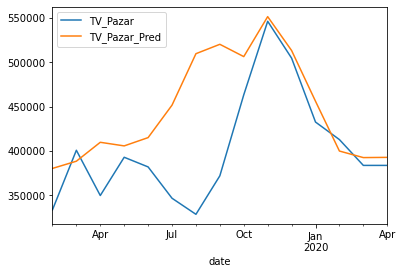

In [57]:
df_final[['TV_Pazar','TV_Pazar_Pred']].plot()

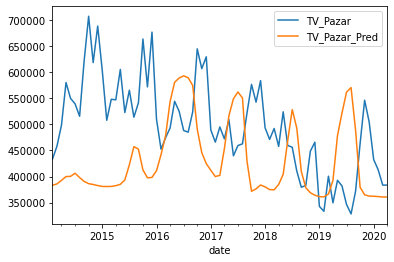

In [58]:
df_final_train[['TV_Pazar','TV_Pazar_Pred']].plot()

# How to improve Model Performance
1- More continous data should be added 

2- Dataset may contain more precise and less null values

3- Categorical variables need to be encoded more precisely

Important Note: As known, after 2020 pandemic spreaded all around the world and this shock undoubtedly affected the data dramatically. Thus, in order to predict 2020, model need old datas from 2019 but there are huge behavioral differences with 2019 and 2020 year datas and It may run upside down the prediction.